In [8]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
import torchvision.ops as ops
from tqdm import tqdm
import numpy as np
from typing import Literal

from src.data_modules.detection_data_module import CbisDdsmDataModuleDetection
from src.models.detection_model import DetectionModel

In [9]:
BATCH_SIZE = 5

datamodule = CbisDdsmDataModuleDetection(
    root_dir="data/cbis-ddsm-detec",
    tumor_type="mass",
    batch_size=BATCH_SIZE,
    num_workers=4,
)

In [10]:
model = DetectionModel(weight_path="models/mass-detection.ckpt")
model = model.eval()

Loaded weights from models/mass-detection.ckpt


/Users/fustosgergo/Documents/BME/10_felev/mammo-vision/src/models/detection_model.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, m

In [11]:
def calculate_iou(boxA, boxB):
    # box: [xmin, ymin, xmax, ymax]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)


def calculate_metrics(ground_truth_boxes, predicted_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    matched_ground_truth = set()
    iou_sum = 0

    for pred in predicted_boxes:
        best_iou = 0
        best_ground_truth_idx = -1
        for idx, ground_truth in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred, ground_truth)
            if iou > best_iou:
                best_iou = iou
                best_ground_truth_idx = idx
        if (
            best_iou >= iou_threshold
            and best_ground_truth_idx not in matched_ground_truth
        ):
            true_positives += 1
            matched_ground_truth.add(best_ground_truth_idx)
            iou_sum += best_iou
        else:
            false_positives += 1

    false_negatives = len(ground_truth_boxes) - len(matched_ground_truth)
    return true_positives, false_positives, false_negatives, iou_sum


def precision(true_positives, false_positives):
    if true_positives + false_positives == 0:
        return 1 if true_positives == 0 else 0
    return true_positives / (true_positives + false_positives)


def recall(true_positives, false_negatives):
    if true_positives + false_negatives == 0:
        return 1 if true_positives == 0 else 0
    return true_positives / (true_positives + false_negatives)


def f1_score(true_positives, false_positives, false_negatives):
    p = precision(true_positives, false_positives)
    r = recall(true_positives, false_negatives)
    if p + r == 0:
        return 0
    return 2 * (p * r) / (p + r)

In [12]:
def evaluate_model(model, val_dataloader, confidence_threshold, iou_threshold, quiet=False):
    total_tp, total_fp, total_fn, total_iou_sum = 0, 0, 0, 0

    for batch in tqdm(val_dataloader, desc="Evaluating", disable=quiet):
        xs, ys = batch[0], batch[1]

        model.eval()
        with torch.no_grad():
            pred = model(xs)

        for i in range(len(xs)):
            scores = pred[i]["scores"]
            boxes = pred[i]["boxes"]
            gt_boxes = ys[i]["boxes"]
            predicted_boxes = boxes[scores > confidence_threshold]
            keep_indices = ops.nms(
                predicted_boxes,
                scores[scores > confidence_threshold],
                iou_threshold,
            )
            # Filtered results
            filtered_boxes = predicted_boxes[keep_indices]

            tp, fp, fn, iou_sum = calculate_metrics(
                gt_boxes.cpu().numpy(),
                filtered_boxes.cpu().numpy(),
                iou_threshold=iou_threshold,
            )
            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_iou_sum += iou_sum

    total_number = total_tp + total_fp + total_fn
    mean_iou_tp = total_iou_sum / total_tp if total_tp > 0 else 0
    mean_iou_all = total_iou_sum / total_number if total_number > 0 else 0

    if not quiet:
        print(f"True Positives: {total_tp}")
        print(f"False Positives: {total_fp}")
        print(f"False Negatives: {total_fn}")
        print(f"Mean IoU: {mean_iou_all:.4f}")
        print(f"Mean IoU (TP): {mean_iou_tp:.4f}")

    return total_tp, total_fp, total_fn, mean_iou_all, mean_iou_tp

In [13]:
def threshold_analysis(
    model,
    threshold_name: Literal["confidence", "iou"],
    thresholds
):
    precisions, recalls, f1s = [], [], []

    dataloader = datamodule.val_dataloader()

    for t in tqdm(thresholds, desc="Threshold Analysis", position=0):
        if threshold_name == "iou":
            tp, fp, fn, _, __ = evaluate_model(
                model, dataloader, confidence_threshold=0.5, iou_threshold=t, quiet=True
            )
        else:
            tp, fp, fn, _, __ = evaluate_model(
                model, dataloader, confidence_threshold=t, iou_threshold=0.3, quiet=True
            )

        p = precision(tp, fp)
        r = recall(tp, fn)
        f1 = f1_score(tp, fp, fn)

        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    plt.figure()
    plt.plot(recalls, precisions, marker="o")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()

    plt.figure()
    plt.plot(thresholds, f1s, marker="o")
    if threshold_name == "iou":
        plt.xlabel("IoU Threshold")
        plt.title("F1 vs IoU Threshold")
    else:
        plt.xlabel("Confidence Threshold")
        plt.title("F1 vs Confidence Threshold")

    plt.ylabel("F1 Score")
    plt.grid()

    plt.show()

### Confidenece threshold

Threshold Analysis: 100%|██████████| 11/11 [31:26<00:00, 171.49s/it]


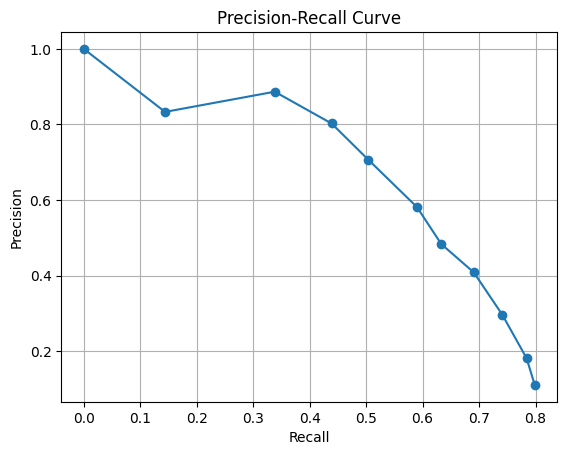

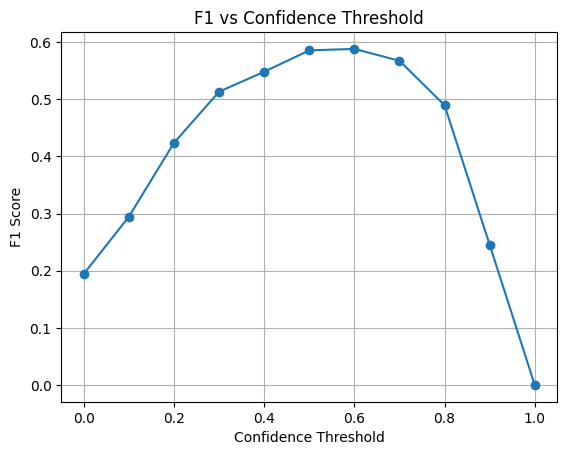

In [14]:
thresholds = np.linspace(0.0, 1.0, 11)
threshold_analysis(
    model,
    threshold_name="confidence",
    thresholds=thresholds,
)

## IoU

Threshold Analysis: 100%|██████████| 9/9 [24:38<00:00, 164.27s/it]


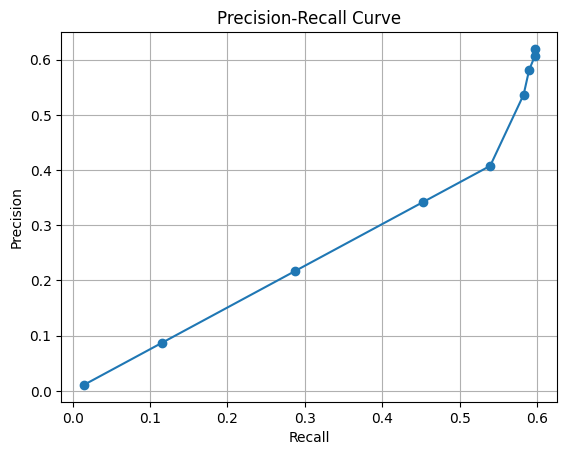

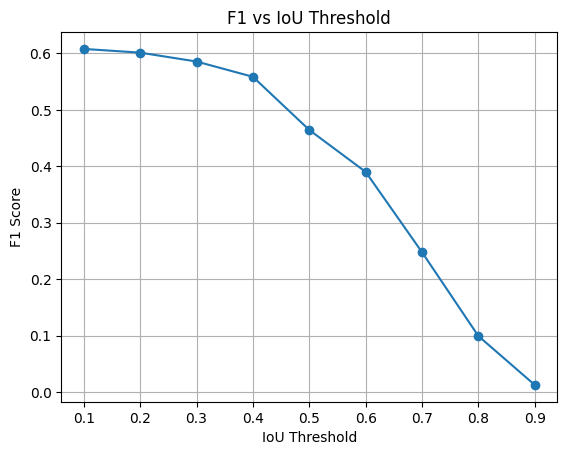

In [15]:
ious = np.linspace(0.1, 0.9, 9)
threshold_analysis(
    model,
    threshold_name="iou",
    thresholds=ious,
)

In [16]:
evaluate_model(
    model,
    datamodule.val_dataloader(),
    confidence_threshold=0.4,
    iou_threshold=0.3,
)

Evaluating: 100%|██████████| 25/25 [02:39<00:00,  6.39s/it]

True Positives: 88
False Positives: 94
False Negatives: 51
Mean IoU: 0.2411
Mean IoU (TP): 0.6384


(88, 94, 51, 0.24112990635507753, 0.6384462293265121)